In [184]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import random

In [185]:
df = pd.read_csv('data/em_data.txt', delim_whitespace=True, header=None)
# to numpy
data = df.values.flatten()
print(type(data), data.shape)

<class 'numpy.ndarray'> (1000,)


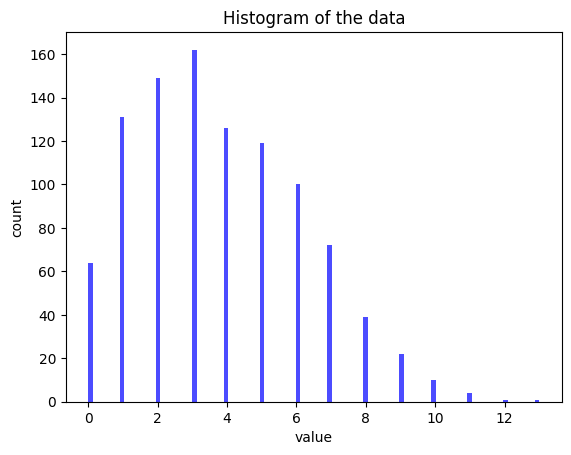

In [186]:
# separated bar plot
fig, ax = plt.subplots()
ax.hist(data, bins=100, color='blue', alpha=0.7)
ax.set_xlabel('value')
ax.set_ylabel('count')
ax.set_title('Histogram of the data')
plt.show()

In [187]:
mean_1, mean_2 = random.randint(1, 5), random.randint(1, 5)
proportion_1, proportion_2 = 0.5, 0.5
log_likelihoods = []

In [188]:
def expectation_step(data, mean_1, mean_2, proportion_1, proportion_2, max_iter=1000, tol=1e-9):
    n=len(data)
    previous_log_likelihood = -np.inf
    for i in range(max_iter):

        # E-Step: Compute expected values (responsibilities) for Z_ij
        # Z_ij = prob that family j belongs to grp i
        prob_1 = proportion_1 * poisson.pmf(data, mean_1)
        prob_2 = proportion_2 * poisson.pmf(data, mean_2)
        prob_sum = prob_1 + prob_2

        # expected values of Z_ij
        prob_1 = prob_1 / prob_sum # Z_1j 
        prob_2 = 1 - prob_1 # Z_2j 

        # M step
        mean_1_new = np.dot(prob_1, data) / np.sum(prob_1) 
        mean_2_new = np.dot(prob_2, data) / np.sum(prob_2)
        proportion_1_new = np.sum(prob_1) / n
        proportion_2_new = 1 - proportion_1_new

        # if np.abs(mean_1_new - mean_1) < tol and np.abs(mean_2_new - mean_2) < tol and np.abs(proportion_1_new - proportion_1) < tol and np.abs(proportion_2_new - proportion_2) < tol:
        #     break

        log_likelihood =  np.sum(np.log(proportion_1 * poisson.pmf(data, mean_1) + proportion_2 * poisson.pmf(data, mean_2)))
        log_likelihoods.append(log_likelihood)

        #print(f"Iteration {i + 1}, diff: {abs(log_likelihood - previous_log_likelihood)}")

        if abs(log_likelihood - previous_log_likelihood) < tol:
            break

        previous_log_likelihood = log_likelihood

        mean_1, mean_2 = mean_1_new, mean_2_new
        proportion_1, proportion_2 = proportion_1_new, proportion_2_new

    return mean_1, mean_2, proportion_1, proportion_2, log_likelihoods


In [189]:
mean_1, mean_2, proportion_1, proportion_2, log_likelihoods = expectation_step(data, mean_1, mean_2, proportion_1, proportion_2)
print("Estimated Parameters:")
print(f"Mean number of children (with family planning): {mean_1}")
print(f"Mean number of children (without family planning): {mean_2}")
print(f"Proportion of families with family planning: {proportion_1}")
print(f"Proportion of families without family planning: {proportion_2}")

Estimated Parameters:
Mean number of children (with family planning): 1.7823957635828787
Mean number of children (without family planning): 4.910708656549717
Proportion of families with family planning: 0.3560093554112149
Proportion of families without family planning: 0.6439906445887851


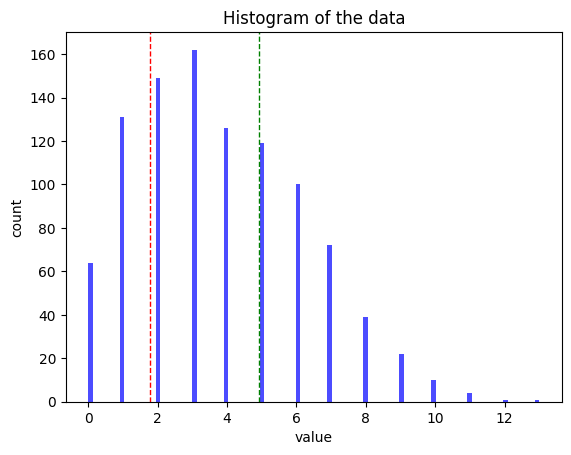

In [190]:
# plot
# x = np.arange(0, 14)
# y = poisson.pmf(x, mean_1) * proportion_1 + poisson.pmf(x, mean_2) * proportion_2
# plt.bar(x, y, width=0.1)
# plt.show()

fig, ax = plt.subplots()
ax.hist(data, bins=100, color='blue', alpha=0.7)
ax.set_xlabel('value')
ax.set_ylabel('count')
ax.set_title('Histogram of the data')
ax.axvline(mean_1, color='red', linestyle='dashed', linewidth=1)
ax.axvline(mean_2, color='green', linestyle='dashed', linewidth=1)
plt.show()


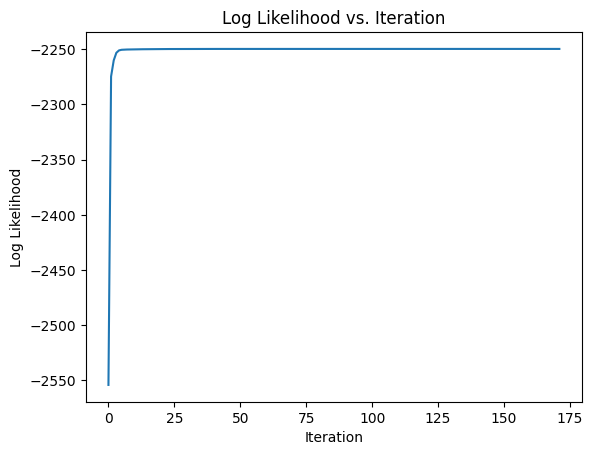

In [191]:
# plot log likelihood
plt.plot(log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood vs. Iteration')
plt.show()